# Collation

In [96]:
%matplotlib inline
import matplotlib.style
matplotlib.style.use('seaborn-deep')
import matplotlib.pyplot as plt

In [4]:
from lxml import etree
from collections import OrderedDict

def load_potter(fn):
    series = etree.parse(fn)
    HP = OrderedDict()
    for book in series.iterfind('.//book'):
        book_title = book.attrib['title']
        #print(book_title)
        HP[book_title] = OrderedDict()
        
        for chapter in book.iterfind('.//chapter'):
            chapter_title = chapter.attrib['title']
            #print('   ', chapter_title)
            HP[book_title][chapter_title] = []
            
            for paragraph in chapter.iterfind('.//p'):
                text = ''.join([x for x in paragraph.itertext()])
                HP[book_title][chapter_title].append(text)
    return HP

UK_HP = load_potter('../preprocessing/simple_potter_uk.xml')
US_HP = load_potter('../preprocessing/simple_potter_us.xml')

## General statistics

Overall length in characters. **V**= "What she needs is a good editor"; boeken langer geworden maar kwaliteit niet gestegen?

Harry Potter and the Philosopher's Stone vs Harry Potter and the Sorcerer's Stone
Harry Potter and the Chamber of Secrets vs Harry Potter and the Chamber of Secrets
Harry Potter and the Prisoner of Azkaban vs Harry Potter and the Prisoner of Azkaban
Harry Potter and the Goblet of Fire vs Harry Potter and the Goblet of Fire
Harry Potter and the Order of the Phoenix vs Harry Potter and the Order of the Phoenix
Harry Potter and the Half Blood Prince vs Harry Potter and the Half-Blood Prince
Harry Potter and the Deathly Hallows vs Harry Potter and the Deathly Hallows


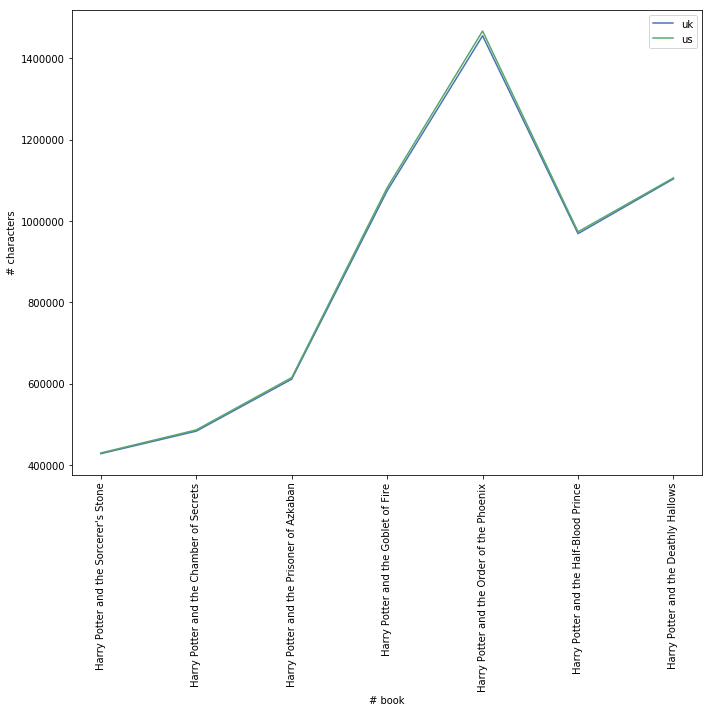

In [98]:
uk_len, us_len, uk_titles  = [], [], []

for uk_book, us_book in zip(UK_HP, US_HP):
    print(uk_book, 'vs', us_book)
    uk_titles.append(us_book)
    
    uk_cnt, us_cnt = 0, 0
    for uk_chap, us_chap in zip(UK_HP[uk_book], US_HP[us_book]):
        uk_text = ' '.join(UK_HP[uk_book][uk_chap])
        us_text = ' '.join(US_HP[us_book][us_chap])
        
        uk_cnt += len(uk_text)
        us_cnt += len(us_text)
    
    uk_len.append(uk_cnt)
    us_len.append(us_cnt)

plt.figure(figsize=(10, 10))
plt.plot(uk_len, label='uk')
plt.plot(us_len, label='us')
plt.legend()
plt.ylabel('# characters')
plt.xlabel('# book')
plt.xticks(range(len(uk_titles)), uk_titles, rotation='vertical')
plt.tight_layout()

## Sentence length

Harry Potter and the Philosopher's Stone vs Harry Potter and the Sorcerer's Stone
Harry Potter and the Chamber of Secrets vs Harry Potter and the Chamber of Secrets
Harry Potter and the Prisoner of Azkaban vs Harry Potter and the Prisoner of Azkaban
Harry Potter and the Goblet of Fire vs Harry Potter and the Goblet of Fire
Harry Potter and the Order of the Phoenix vs Harry Potter and the Order of the Phoenix
Harry Potter and the Half Blood Prince vs Harry Potter and the Half-Blood Prince
Harry Potter and the Deathly Hallows vs Harry Potter and the Deathly Hallows


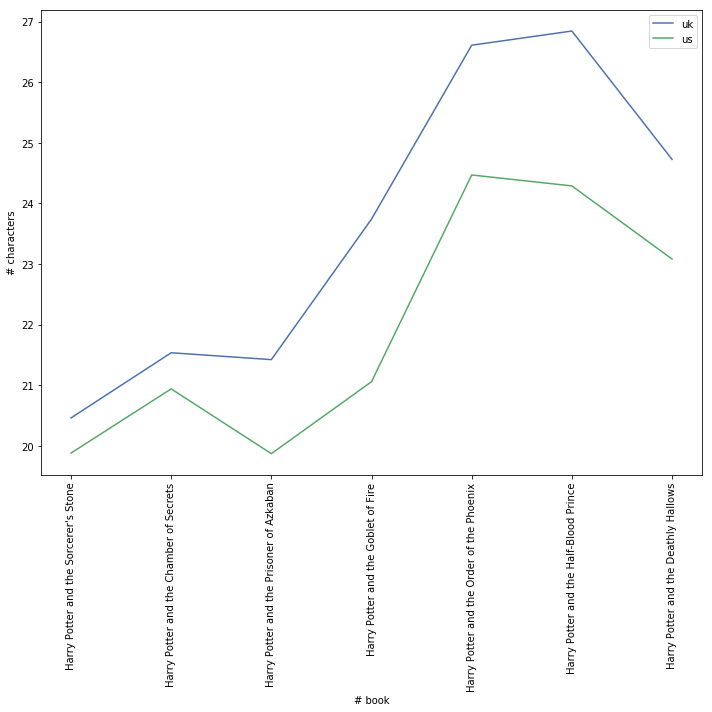

In [99]:
from nltk.tokenize import sent_tokenize
import numpy as np

uk_len, us_len, uk_titles  = [], [], []

for uk_book, us_book in zip(UK_HP, US_HP):
    print(uk_book, 'vs', us_book)
    uk_titles.append(us_book)
    
    uk_cnt, us_cnt = [], []
    for uk_chap, us_chap in zip(UK_HP[uk_book], US_HP[us_book]):
        uk_text = ' '.join(UK_HP[uk_book][uk_chap])
        us_text = ' '.join(US_HP[us_book][us_chap])
        
        us_text = us_text.replace(' . . .', '.')
        
        uk_sents = sent_tokenize(uk_text)
        us_sents = sent_tokenize(us_text)
        
        uk_cnt.extend(len(word_tokenize(s)) for s in uk_sents)
        us_cnt.extend(len(word_tokenize(s)) for s in us_sents)
    
    # now average at chapter level
    uk_len.append(np.mean(uk_cnt))
    us_len.append(np.mean(us_cnt))

plt.figure(figsize=(10, 10))
plt.plot(uk_len, label='uk')
plt.plot(us_len, label='us')
plt.legend()
plt.ylabel('# characters')
plt.xlabel('# book')
plt.xticks(range(len(uk_titles)), uk_titles, rotation='vertical')
plt.tight_layout()

## Collation

(Note: Error in package install via pip; one needs to install `python-Levenshtein` **before** installing Collatex. Detailed instructions go here: http://collatex.obdurodon.org/installation.xhtml)

In [1]:
from collatex import *

collation = Collation()
collation.add_plain_witness("UK", "Harry Potter and the Philosopher's Stone")
collation.add_plain_witness("US", "Harry Potter and the Sorcerer's Stone")

alignment_table = collate(collation)

print(alignment_table)

+----+----------------------+-------------+----------+
| UK | Harry Potter and the | Philosopher | 's Stone |
| US | Harry Potter and the | Sorcerer    | 's Stone |
+----+----------------------+-------------+----------+


In [2]:
for i in alignment_table.columns:
    print(i.tokens_per_witness)
    for idx, tokens in i.tokens_per_witness.items():
        print(tokens)
    print('===')

{'UK': [Harry, Potter, and, the], 'US': [Harry, Potter, and, the]}
[Harry, Potter, and, the]
[Harry, Potter, and, the]
===
{'UK': [Philosopher], 'US': [Sorcerer]}
[Philosopher]
[Sorcerer]
===
{'UK': [', s, Stone], 'US': [', s, Stone]}
[', s, Stone]
[', s, Stone]
===


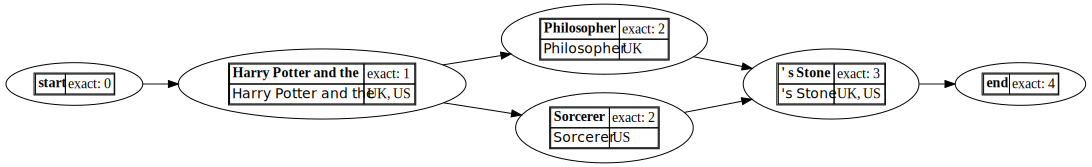

In [12]:
collate(collation,output="svg")

In [9]:
book = "Harry Potter and the Prisoner of Azkaban"
uk_chap = ' '.join(UK_HP[book]['Owl Post'])[:10000]
us_chap = ' '.join(US_HP[book]['OWL POST'])[:10000]

In [10]:
print(uk_chap[:1000])
print(us_chap[:1000])

Harry Potter was a highly unusual boy in many ways. For one thing, he hated the summer holidays more than any other time of year. For another, he really wanted to do his homework, but was forced to do it in secret, in the dead of night. And he also happened to be a wizard. It was nearly midnight, and he was lying on his front in bed, the blankets drawn right over his head like a tent, a torch in one hand and a large leather-bound book (A History of Magic, by Bathilda Bagshot) propped open against the pillow. Harry moved the tip of his eagle-feather quill down the page, frowning as he looked for something that would help him write his essay, ‘Witch-Burning in the Fourteenth Century Was Completely Pointless – discuss’. The quill paused at the top of a likely-looking paragraph. Harry pushed his round glasses up his nose, moved his torch closer to the book and read: Harry put his quill between his teeth and reached underneath his pillow for his ink bottle and a roll of parchment. Slowly an

In [11]:
collation = Collation()
collation.add_plain_witness('UK', uk_chap)
collation.add_plain_witness('US', us_chap)
#alignment_table = collate(collation, layout='vertical')

#collate(collation,output="svg")
#collate(collation, layout='vertical', output='html2')

In [12]:
#alignment_table = collate(collation, layout='vertical')

#collate(collation,output="svg")
collate(collation, layout='vertical', output='html2')

# **Opmerking Vanessa**: anders kleuren naargelang aard van het verschil.

### Java tool CLI interface

In [17]:
import json
import subprocess

def java_alignment(uk_chap, us_chap):
    W = {'witnesses': [{'id': 'uk', 'content': uk_chap},
                       {'id': 'us', 'content': us_chap}]}
    
    with open('in.json', 'w') as f:
        f.write(json.dumps(W))

    subprocess.call("java -jar collatex-tools-1.7.1.jar in.json --output='out.json'", shell=True)
    
    with open('out.json', 'r') as f:
        alignment = json.loads(f.read())
    
    pairs = list(zip(*alignment['table']))
        
    uk = pairs[alignment['witnesses'].index('uk')]
    us = pairs[alignment['witnesses'].index('us')]

    return uk, us

(This takes forever.)

In [18]:
# %timeit java_alignment(uk_chap, us_chap)
# #%timeit collate(collation, layout='vertical')

In [19]:
uk, us = java_alignment(uk_chap, us_chap)

In [20]:
for a, b in zip(uk, us):
    print(''.join(a), ''.join(b))

Harry Potter was a highly unusual boy in many ways. For one thing, he hated the summer holidays more than any other time of year. For another, he really wanted to do his homework Harry Potter was a highly unusual boy in many ways. For one thing, he hated the summer holidays more than any other time of year. For another, he really wanted to do his homework 
,  
but was forced to do it in secret, in the dead of night. And he also happened to be a wizard. It was nearly midnight, and he was lying on his  but was forced to do it in secret, in the dead of night. And he also happened to be a wizard. It was nearly midnight, and he was lying on his 
front  stomach 
in bed, the blankets drawn right over his head like a tent, a  in bed, the blankets drawn right over his head like a tent, a 
torch  flashlight 
in one hand and a large leather-bound book (A History of Magic in one hand and a large leather-bound book (A History of Magic 
,  
by Bathilda Bagshot) propped open against the pillow. Harry

Catch 'plain' synonyms:

In [21]:
from nltk.corpus import wordnet as wn

def is_synonym(w1, w2):
    w1 = w1.strip().lower()
    w2 = w2.strip().lower()
    synonym = False
    for synset in wn.synsets(w1):
        for lemma in synset.lemma_names():
            if lemma.lower() == w2.lower():
                synonym = True
    for synset in wn.synsets(w2):
        for lemma in synset.lemma_names():
            if lemma.lower() == w1.lower():
                synonym = True
    return synonym

print(is_synonym('torch', 'flashlight'))
print(is_synonym('torch', 'dog'))
print(is_synonym('cutting', 'clipping'))

True
False
True


Catch 'standard' spelling differences:

In [22]:
uk_to_us_spellings = []
for line in open('uk_vs_us.txt', 'r'):
    if not line.strip().startswith('#'):
        uk_to_us_spellings.append(line.strip().split())

def is_spelling_diff(w1, w2):
    spelling = False
    w1 = w1.strip().lower()
    w2 = w2.strip().lower()
    
    if ''.join(OrderedDict.fromkeys(w1)) == ''.join(OrderedDict.fromkeys(w2)):
        spelling = True
    elif ''.join(w1.split()) == ''.join(w2.split()):
        spelling = True
    else:
        for british, american in uk_to_us_spellings:
            if w1.endswith(british) and w2.endswith(american):
                spelling = True
    
    return spelling

print(is_spelling_diff('towards', 'toward'))
print(is_spelling_diff('colour', 'color'))
print(is_spelling_diff('analyse', 'analyze'))
print(is_spelling_diff('dog', 'torch'))

True
True
True
False


In [189]:
def score_diffs(uk_chap, us_chap, verbose=False):
    diffs = {'len': len(uk_chap.strip()), # for normalization
             'spell': 0, 'synon': 0, 'style': 0, 'eos': 0}
    
    uk, us = java_alignment(uk_chap, us_chap)

    for a, b in zip(uk, us):
        if not (a is None or b is None):
            a = ''.join(a).strip().lower()
            b = ''.join(b).strip().lower()
            
            a = ''.join([c for c in a if c.isalpha() or c.isspace() or c in ('<', '>')])
            b = ''.join([c for c in b if c.isalpha() or c.isspace() or c in ('<', '>')])
            
            if a and b and a != b:
                if not '<eos>' in a and '<eos>' in b:
                    diffs['eos'] += 1
                    if verbose:
                        print(a, 'vs', b, '-> <EOS>')
                elif is_spelling_diff(a, b):
                    diffs['spell'] += 1
                    if verbose:
                        print(a, 'vs', b, '-> SPELLING')
                elif is_synonym(a, b):
                    diffs['synon'] += 1
                    if verbose:
                        print(a, 'vs', b, '-> SYNONYM')
                else:
                    diffs['style'] += 1
                    if verbose:
                        print(a, 'vs', b, '-> STYLISTIC')
    
    # normalize by the number of characters in the UK chapter
    return diffs

In [191]:
print(score_diffs(uk_chap, us_chap, verbose=True))

{'len': 20, 'spell': 0, 'synon': 0, 'style': 0, 'eos': 0}


In [193]:
UK_HP = load_potter('../preprocessing/simple_potter_uk.xml')
US_HP = load_potter('../preprocessing/simple_potter_us.xml')

import pandas as pd
df = pd.DataFrame(columns=['len', 'spell', 'synon', 'style', 'book', 'chapter'])

for uk_book, us_book in zip(UK_HP, US_HP):
    print(uk_book, 'vs', us_book)
    
    for uk_chap, us_chap in zip(UK_HP[uk_book], US_HP[us_book]):
        print('   ', uk_chap)
        uk_text = ' '.join(UK_HP[uk_book][uk_chap])#[:1000]
        us_text = ' '.join(US_HP[us_book][us_chap])#[:1000]
        
        uk_text = '<EOS> '.join(sent_tokenize(uk_text))
        us_text = '<EOS> '.join(sent_tokenize(us_text))

        score = score_diffs(uk_text, us_text, verbose=False)
        
        print(score)
        print(score['style'] / score['len'])
        score['book'] = uk_book
        score['chapter'] = uk_chap
        
        df = df.append(score, ignore_index=True)

Harry Potter and the Philosopher's Stone vs Harry Potter and the Sorcerer's Stone
    The Boy Who Lived
{'len': 27047, 'spell': 23, 'synon': 6, 'style': 20, 'eos': 4}
0.0007394535438311088
    The Vanishing Glass
{'len': 19968, 'spell': 18, 'synon': 8, 'style': 23, 'eos': 6}
0.0011518429487179487
    The Letters from No One
{'len': 22446, 'spell': 38, 'synon': 8, 'style': 23, 'eos': 4}
0.001024681457720752
    The Keeper of the Keys
{'len': 20743, 'spell': 9, 'synon': 2, 'style': 8, 'eos': 2}
0.00038567227498433206
    Diagon Alley


KeyboardInterrupt: 

**V:**
- Lijst met typische verschillen UK US
- Worden zinnen korter? Zinseindes taggen met speciaal symbool en in apart categorie onderbrengen

In [27]:
df

,len,spell,synon,style,book,chapter
0,25677,26,6,18,Harry Potter and the Philosopher's Stone,The Boy Who Lived
1,18983,23,8,22,Harry Potter and the Philosopher's Stone,The Vanishing Glass
2,21246,41,8,20,Harry Potter and the Philosopher's Stone,The Letters from No One
3,19558,11,2,4,Harry Potter and the Philosopher's Stone,The Keeper of the Keys
4,35890,39,9,28,Harry Potter and the Philosopher's Stone,Diagon Alley
5,34257,49,5,33,Harry Potter and the Philosopher's Stone,The Journey from Platform Nine and Three-Quarters
6,23648,42,3,18,Harry Potter and the Philosopher's Stone,The Sorting Hat
7,16332,16,1,12,Harry Potter and the Philosopher's Stone,The Potions Master
8,28013,30,4,17,Harry Potter and the Philosopher's Stone,The Midnight Duel
9,23695,24,5,14,Harry Potter and the Philosopher's Stone,Hallowe’en


In [28]:
df.to_csv('align.csv')

In [157]:
df = pd.read_csv('align.csv')
df = df.infer_objects()
df['norm'] = df['style'] / df['len']
df.describe()

,Unnamed: 0,len,spell,synon,style,norm
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,99.000000,30765.216080,42.874372,6.216080,18.462312,0.000591
std,57.590508,8828.154793,19.033710,3.960479,13.925753,0.000373
min,0.000000,9444.000000,10.000000,0.000000,0.000000,0.000000
25%,49.500000,24804.500000,28.000000,3.000000,7.500000,0.000280
50%,99.000000,31101.000000,39.000000,6.000000,16.000000,0.000591
75%,148.500000,36681.500000,51.000000,8.000000,25.000000,0.000833
max,198.000000,50533.000000,105.000000,21.000000,69.000000,0.001832


Text(0.5,0,'chapters')

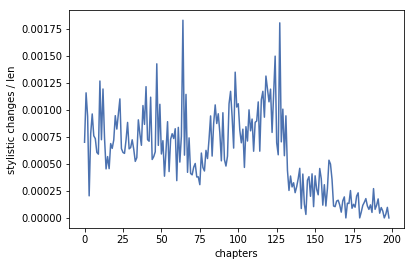

In [173]:
ax = df['norm'].plot()
ax.set_ylabel('stylistic changes / len')
ax.set_xlabel('chapters')

([<matplotlib.axis.XTick at 0x1a2881a550>,
 <a list of 7 Text xticklabel objects>)

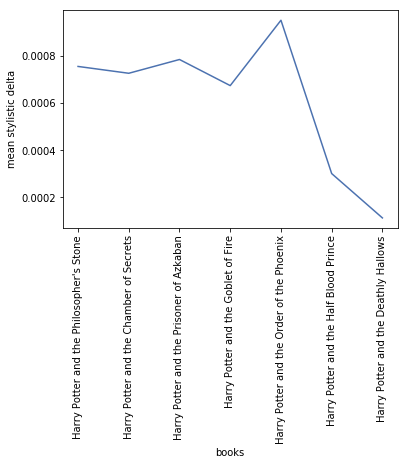

In [188]:
ax = df.groupby('book', sort=False)['norm'].mean().plot()
ax.set_ylabel('mean stylistic delta')
ax.set_xlabel('books')
t = list(df['book'].unique())
plt.xticks(range(len(t)), t, rotation='vertical')